In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from src.env import *
from src.imports import *
from src.config import *
from src.dataset import *
from src.metric import *

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-f628ff2f2d994b84/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-a84cfc0a0e11ed54.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-665145fe0a5a6a51.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-e104a2bffe25c7fa.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-4096519e2393e19f.arrow


<IPython.core.display.Javascript object>

In [3]:
enc_name = "microsoft/deberta-v3-base"
dec_name = "bert-base-multilingual-cased"
model_name = "bert2bert_new"

<IPython.core.display.Javascript object>

In [4]:
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
enc_tokenizer.bos_token = enc_tokenizer.cls_token
enc_tokenizer.eos_token = enc_tokenizer.sep_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\tempjeka\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<IPython.core.display.Javascript object>

In [5]:
dec_tokenizer = AutoTokenizer.from_pretrained(dec_name)
dec_tokenizer.bos_token = enc_tokenizer.cls_token
dec_tokenizer.eos_token = enc_tokenizer.sep_token

<IPython.core.display.Javascript object>

In [6]:
def create_dataset(enc_tokenizer: AutoTokenizer, dec_tokenizer: AutoTokenizer | None = None):
    if dec_tokenizer is None:
        dec_tokenizer = enc_tokenizer
    
    def preprocess_function(batch):
        inputs = enc_tokenizer(
            [(prefix + ex[source_lang]).strip() for ex in batch["translation"]],
            max_length=max_input_length,
            truncation=True,
            padding="max_length",
        )
        outputs = dec_tokenizer(
            [ex[target_lang].strip() for ex in batch["translation"]],
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask
        batch["decoder_attention_mask"] = outputs.attention_mask
        batch["labels"] = outputs.input_ids.copy()

        batch["labels"] = [
            [-100 if token == dec_tokenizer.pad_token_id else token for token in labels]
            for labels in batch["labels"]
        ]
        return batch
    
    dataset = DatasetDict(
        dict(train=test["train"], val=val["train"], test=val["test"])
    ).map(preprocess_function, batched=True, batch_size=batch_size)
    dataset.set_format(
        type="torch",
        columns=[
            "input_ids",
            "attention_mask",
            "decoder_attention_mask",
            "labels",
        ],
    )
    return dataset

dataset = create_dataset(enc_tokenizer, dec_tokenizer)

Loading cached processed dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-61f302a720aeded5.arrow
Loading cached processed dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-a7bea249963ea03a.arrow
Loading cached processed dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-63ec7514534fd7b2.arrow


<IPython.core.display.Javascript object>

По-разному считался loss. 
Bert: https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py#L1253 EncoderDecoder: https://github.com/huggingface/transformers/blob/v4.29.1/src/transformers/models/encoder_decoder/modeling_encoder_decoder.py#L632

In [7]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(enc_name, dec_name)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the m

<IPython.core.display.Javascript object>

In [8]:
model.config.decoder_start_token_id = dec_tokenizer.bos_token_id
model.config.pad_token_id = enc_tokenizer.pad_token_id

model.config.eos_token_id = dec_tokenizer.eos_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.decoder.bos_token_id = dec_tokenizer.bos_token_id

model.config.max_length = max_input_length
model.config.min_length = 10
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.num_beams = 10

<IPython.core.display.Javascript object>

In [9]:
version = 12

<IPython.core.display.Javascript object>

In [10]:
version += 1
args = Seq2SeqTrainingArguments(
    output_dir=Path("models") / model_name,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    lr_scheduler_type="constant_with_warmup",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=2,
    predict_with_generate=True,
    warmup_steps=1000,
    fp16=True,
    logging_dir=f"../made/logs/lightning_logs/{model_name}/{version}",
    logging_first_step=False,
    eval_steps=1000,
    logging_steps=500,
    overwrite_output_dir=True,
)

<IPython.core.display.Javascript object>

In [11]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    compute_metrics=partial(compute_metrics, dec_tokenizer, metric),
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

<IPython.core.display.Javascript object>

In [12]:
trainer.train()

C:\tempjeka\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Bleu,Gen Len
1000,2.694700,2.176707,0.062923,59.000000
2000,2.186000,1.851602,0.085468,68.360000
3000,1.940400,1.726119,0.116923,83.600000
4000,1.794000,1.558923,0.122397,85.780000
5000,1.712900,1.482391,0.163354,84.680000
6000,1.702300,1.406963,0.173773,78.460000
7000,1.556500,1.371082,0.201633,83.520000
8000,1.519200,1.303877,0.201320,85.040000
9000,1.475300,1.224885,0.235053,85.940000
10000,1.416100,1.217995,0.236996,83.360000


C:\tempjeka\anaconda3\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
C:\tempjeka\anaconda3\lib\site-packages\transformers\

TrainOutput(global_step=22500, training_loss=1.5254408203125, metrics={'train_runtime': 8574.1522, 'train_samples_per_second': 10.497, 'train_steps_per_second': 2.624, 'total_flos': 1.376815511808e+16, 'train_loss': 1.5254408203125, 'epoch': 2.0})

<IPython.core.display.Javascript object>

In [13]:
model.save_pretrained(model_name)

<IPython.core.display.Javascript object>

In [7]:
model = EncoderDecoderModel.from_pretrained(model_name)

<IPython.core.display.Javascript object>

In [ ]:
def compute_metrics_test(model, tokenizer, metric, batch, log=False):
    preds = model.generate(
        batch["input_ids"].cuda(),
        attention_mask=batch["attention_mask"].cuda(),
    ).cpu()
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = batch["labels"]
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    metric.add_batch(references=decoded_labels, predictions=decoded_preds)
    if log:
        print(list(zip(decoded_preds, decoded_labels)))

In [8]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
with torch.no_grad():
    dataset["test"].map(
        partial(compute_metrics_test, model, dec_tokenizer, metric),
        batched=True,
        batch_size=batch_size,
    )

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<IPython.core.display.Javascript object>

In [9]:
metric.compute()

{'bleu': 0.2678466521731837,
 'precisions': [0.5717559687853558,
  0.3596387048381048,
  0.25805358897056335,
  0.18575759816608742],
 'brevity_penalty': 0.850066334168694,
 'length_ratio': 0.860258793875794,
 'translation_length': 68942,
 'reference_length': 80141}

<IPython.core.display.Javascript object>

In [11]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
with torch.no_grad():
    dataset["test"].select(range(4)).map(
        partial(compute_metrics_test, model, dec_tokenizer, metric, log=True),
        batched=True,
        batch_size=batch_size,
    )

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

[('В ресторане отеля подают разнообразные блюда интернациональной кухни. Из окон открывается панорамный вид на море.', ['В ресторане отеля подают разнообразные блюда интернациональной кухни в формате " шведский стол ". Блюда можно отведать у бассейна с панорамным видом на море.']), ('К услугам гостей бесплатный Wi - Fi и парковка.', ['WiFi и парковка предоставляются бесплатно.']), ('К услугам гостей бесплатный Wi - Fi на всей территории.', ['К услугам гостей бесплатный Wi - Fi во всех зонах и бесплатная частная парковка на территории.']), ('В собственной ванной комнате с душем предоставляются бесплатные туалетно - косметические принадлежности.', ['В собственной ванной комнате с душем предоставляются бесплатные туалетно - косметические принадлежности.'])]


<IPython.core.display.Javascript object>

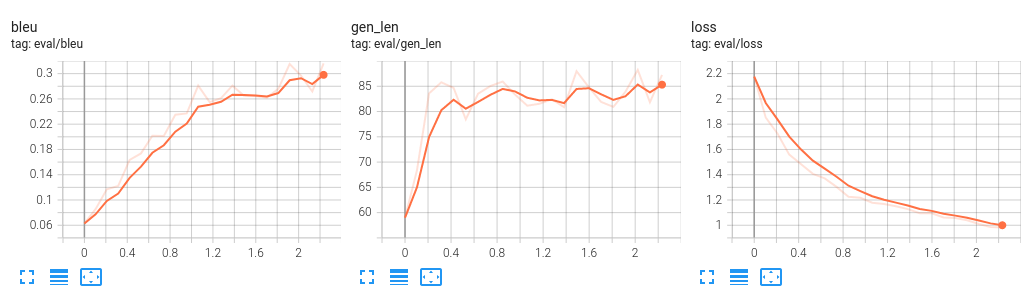 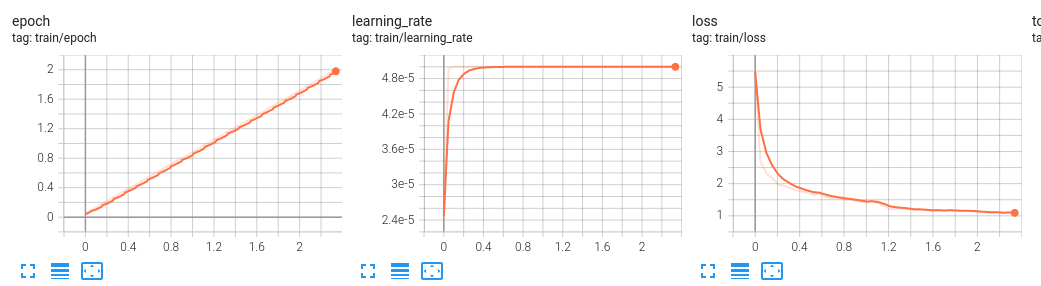